In [1]:
import matplotlib.pyplot as plt

import astroalign as aa
from astropy.io import fits

import numpy as np

import matplotlib.colors as colors


In [2]:
def remove_oscan(hdr, data):
    #four channels
    nchan=4
    eff_regions = np.array([[[hdr[f'S_EFMN{i}{ax}'], hdr[f'S_EFMx{i}{ax}'] ]\
                             for i in range(1,nchan+1)] for ax in [1,2]])

    #effective columns are page 0 of the above array
    #effective rows are page 1 of the above array
    eff_cols = np.concatenate([np.arange(eff_regions[0,c,0],eff_regions[0,c,1]+1)for c in range(nchan)])
    eff_rows = np.concatenate([np.arange(eff_regions[1,c,0],eff_regions[1,c,1]+1)for c in range(nchan)])
    
    #unique-ify and subtract 1 for python indexing
    # relying on np.unique to return array in sorted order
    eff_rows = np.unique(eff_rows)-1
    eff_cols = np.unique(eff_cols)-1

    no_oscan = np.array([data[row][eff_cols] for row in eff_rows])

    return no_oscan


In [30]:
with fits.open(r'C:\Users\Kevin\repos\ReipurthBallyProject\data\M8\no_bias\SUPA01564803.fits') as f:
    img_hdr = f[0].header.copy()
    img_data = f[0].data.copy()
    #take out the overscan
    img_data = remove_oscan(img_hdr, img_data)
with fits.open(r'C:\Users\Kevin\repos\ReipurthBallyProject\data\M8\false_image\SUPA01564803.fits') as f:
    false_hdr = f[0].header.copy()
    false_data = f[0].data.copy()

#img_data = img_data.byteswap(inplace=True).newbyteorder()
#false_data = false_data.byteswap(inplace=True).newbyteorder()

In [ ]:
with fits.open(r'C:\Users\Kevin\repos\ReipurthBallyProject\data\ZCMa\no_bias\HH34_sii.fits') as f:
    img1_hdr = f[0].header.copy()
    img1_data = f[0].data.copy()
    #take out the overscan
    #img1_data = remove_oscan(img1_hdr, img1_data)
with fits.open(r'C:\Users\Kevin\repos\ReipurthBallyProject\data\ZCMa\false_image\HH34_sii.fits') as f:
    false1_hdr = f[0].header.copy()
    false1_data = f[0].data.copy()
    
img1_data = img1_data.byteswap(inplace=True).newbyteorder()
false1_data = false1_data.byteswap(inplace=True).newbyteorder()

In [4]:
import sep
sep.set_extract_pixstack(5000000)
sep.get_extract_pixstack()

5000000

In [5]:
sep.get_sub_object_limit()

1024

## Experiment
See what registers and what doesn't

Using HH34_ha and HH34_sii, create false images for both -- these should be nearly identical since they are the same image, just different filters.

Try registering:

- HH34_ha against HH34_sii, the real images, should work but doesn't
- HH34_ha against HH34_ha_false - should work but doesn't
- HH34_sii against HH34_sii_false - should work but doesn't
- HH34_ha_false against HH34_sii_false - should work and does!!

In [36]:
img_ma = np.ma.masked_array(img_data, mask = img_data < 3000)
img_ma_norm = (img_ma - img_ma.mean())/img_ma.std()
false_data_norm = (false_data-false_data.mean())/false_data.std()

registered_image, footprint = aa.register(img_ma_norm, false_data_norm, fill_value=np.nan)

MaxIterError: List of matching triangles exhausted before an acceptable transformation was found

Text(0.5, 1.0, 'normalized Image')

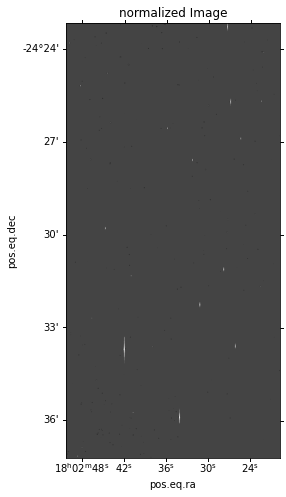

In [39]:
wcs = WCS(false_hdr)
fig = plt.figure(figsize=(8,8))
ax2 = plt.subplot(111, projection=wcs)

ax2.imshow(np.ma.filled(img_ma_norm,fill_value=0)+5,   origin='lower', cmap=cmap)
ax2.set_title('normalized Image')

In [32]:
img_clipped = np.where(img_data > 3000, img_data, 0.001)
registered_image, footprint = aa.register(img_clipped, false_data, fill_value=np.nan)

MaxIterError: List of matching triangles exhausted before an acceptable transformation was found

In [21]:
import matplotlib as mpl
from astropy.wcs import WCS

wcs = WCS(false_hdr)

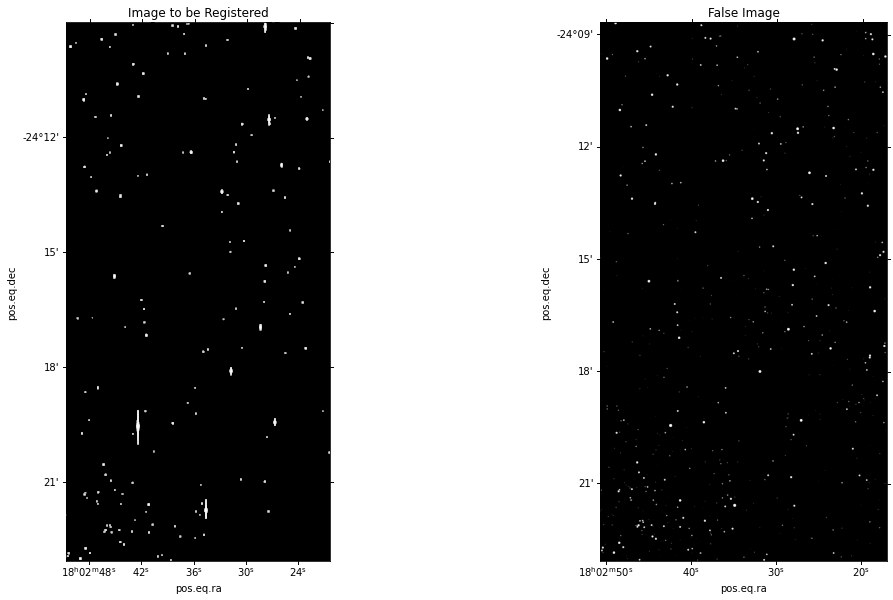

In [33]:
cmap = mpl.cm.binary_r.copy()
cmap.set_bad(color='blue')

vmin=100; vmax=1500
fig = plt.figure(figsize=(24,8))
ax3 = plt.subplot(131, projection=wcs)
#img_clipped = np.clip(img_data,np.percentile(img_data, 0.5), np.percentile(img_data,99.5))
img_clipped = np.where(img_data > 5000, img_data, 0.001)
ax3.imshow(img_clipped,   origin='lower', cmap=cmap, norm=colors.LogNorm())#a_min=vmin, a_max=vmax,
ax3.set_title('Image to be Registered')

ax1 = plt.subplot(132, projection=wcs)
false_clipped = np.clip(false_data,a_min=vmin, a_max= vmax)
ax1.imshow(false_clipped,  origin='lower', cmap=cmap, norm=colors.LogNorm())
ax1.set_title('False Image')

# ax2 = plt.subplot(133, projection=wcs)
# reg_clipped = np.clip(registered_image,np.nanpercentile(registered_image, 0.5), np.nanpercentile(registered_image,99.5))


# ax2.imshow(reg_clipped,   origin='lower', cmap=cmap, norm=colors.LogNorm())
# ax2.set_title('Registered Image')



fig.tight_layout()

Text(0.5, 1.0, 'clipped Image')

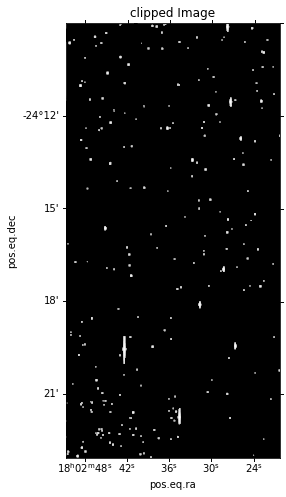

In [31]:
fig = plt.figure(figsize=(8,8))
ax2 = plt.subplot(111, projection=wcs)
img_clipped = np.where(img_data > 3000, img_data, 0.001)


ax2.imshow(img_clipped,   origin='lower', cmap=cmap, norm=colors.LogNorm())
ax2.set_title('clipped Image')

In [13]:
np.percentile(registered_image, 1.0), np.percentile(registered_image,99)

(nan, nan)

In [11]:
footprint.sum(), np.isnan(registered_image).sum()

(1337349, 1337349)

In [ ]:
np.nanmin(registered_image), np.nanmax(registered_image)


In [ ]:
np.nanmin(img_data), np.nanmax(img_data)

In [ ]:
img_data.dtype

In [ ]:
new_hdr = wcs.to_header()
phdu = fits.PrimaryHDU(data = registered_image, header=new_hdr)
phdu.writeto('../data/registered_image.fits', overwrite=True)

In [ ]:
fig = plt.figure(figsize=(8,8))
ax3 = plt.subplot(111, projection=wcs)
ax3.imshow(footprint,  origin='lower', cmap='Reds')
ax3.set_title('Footprint')

## Align overscan subracted images?

In [ ]:
with fits.open(r'C:\Users\Kevin\repos\ReipurthBallyProject\data\M8\no_bias\SUPA01564801.fits') as f:
    img1_hdr = f[0].header.copy()
    wcs = WCS(img1_hdr)
    img1_data = f[0].data.copy()
    #take out the overscan
    img1_data = remove_oscan(img1_hdr, img1_data)
with fits.open(r'C:\Users\Kevin\repos\ReipurthBallyProject\data\M8\no_bias\SUPA01564811.fits') as f:
    img11_hdr = f[0].header.copy()
    img11_data = f[0].data.copy()
    img11_data = remove_oscan(img11_hdr, img11_data)
    
#img1_data = img1_data.byteswap(inplace=True).newbyteorder()
#false1_data = false1_data.byteswap(inplace=True).newbyteorder()

In [ ]:
registered_image, footprint = aa.register(img11_data, img1_data, fill_value = np.nan)

In [ ]:
vmin=1000; vmax=25000
fig = plt.figure(figsize=(24,8))
ax1 = plt.subplot(131, projection=wcs)
ax1.imshow(img11_data,  origin='lower', cmap='binary_r', norm=colors.LogNorm(vmin=vmin, vmax=vmax))
ax1.set_title('Image to be Registered')

ax2 = plt.subplot(133, projection=wcs)
ax2.imshow(registered_image,   origin='lower', cmap='binary_r', norm=colors.LogNorm(vmin=vmin, vmax=vmax))
ax2.set_title('Registered Image')

ax3 = plt.subplot(132, projection=wcs)
ax3.imshow(img1_data,  origin='lower', cmap='binary_r', norm=colors.LogNorm(vmin=vmin, vmax=vmax))
ax3.set_title('Target of Registration')

In [ ]:
fig = plt.figure(figsize=(8,8))
ax1 = plt.subplot(111, projection=wcs)
ax1.imshow(footprint,  origin='lower', cmap='binary_r')

In [ ]:
fig = plt.figure(figsize=(16,8))
ax = plt.subplot(121,projection=wcs)
ax.imshow(img_data, origin='lower', cmap='gray', norm=colors.LogNorm(vmin=500, vmax=30000))
ax = plt.subplot(122,projection=wcs)
ax.imshow(img1_data, origin='lower', cmap='gray', norm=colors.LogNorm(vmin=500, vmax=30000))

In [ ]:
img_registered, footprint = aa.register(img1_data, img_data)

In [ ]:
fig = plt.figure(figsize=(24,8))
ax1 = plt.subplot(131, projection=wcs)
ax1.imshow(img_data,  origin='lower', cmap='binary_r', norm=colors.LogNorm())
ax2 = plt.subplot(132, projection=wcs)
ax2.imshow(img_registered,  origin='lower', cmap='binary_r', norm=colors.LogNorm())
ax3 = plt.subplot(133, projection=wcs)
ax3.imshow(img1_data,  origin='lower', cmap='binary_r', norm=colors.LogNorm())

In [ ]:
registered_image, footprint = aa.register(img_data, false_data)

[Subprime Data Reduction Guide](https://www.subarutelescope.org/Observing/Instruments/SCam/sdfred/sdfred2.html.en)
